### Non-ideal reaction-diffusion systems

In the last notebook you learned the basics of phase separation driven by the competition between entropy (favoring mixing) and non-ideal interactions (favoring demixing). In this notebook you will see how first order reactions can introduce patterns of a certain length scale.

In [1]:
''' Import the packages that we need for this tutorial '''
import sys
import numpy as np
import matplotlib.pyplot as plt

import pde

We build upon the last notebook, where the concentration field $c(x,y,t)$ describes the state of the system. But now the dynamics are not given by diffusion only, instead the particles can react as well and we introduce a reactive flux $s$ that describes how many $A$ particles are created $s>0$ or destroyed $s<0$ per unit time. In this case the full dynamics are given by

\begin{align}
    \partial_t c(x,y,t) = M\nabla^2 \mu (x,y,t) + s(x,y,t)
\end{align}

where we assume a constant diffusive mobility $M$.

We assume a simple switch between the two particle types $A\rightleftharpoons B$, where $A\rightarrow B$ proceeds with rate $k_f$ and $B\rightarrow A$ with rate $k_b$. The total change of $A$ particles is then given by $s=-k_fc_A + k_bc_B=-k_fc+k_b(1-c)$, using $c_A=c$ and $c_B=1-c_A$. 

### Reactions in a homogeneous mixture

We neglect diffusion for now and discuss the reactive flux $s$ only.

### Problem 1

For constant $k_f$ and $k_b$, calculate the concentration $c_0$ for which $s(c)=-k_f c+k_b(1-c)$ vanishes. Afterwards plot $s(c)$ for $k_f=1$ and $k_b=0.3k_f$. For a given $c(t=0)$ and use it to explain the dynamics $\partial_t c = -k_f c + k_b(1-c)$.<br>
Then determine the slope $-k$ in terms of $k_f$ and $k_b$ and express $s(c)$ in terms of $k$ and $c_0$.

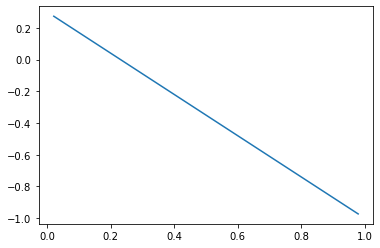

In [2]:
kf = 1
kb = 0.3*kf
c = np.linspace(0, 1)[1:-1]

plt.plot(c,-kf*c+kb*(1-c))

### Solution 1

For $c>c_0$ $s<0$ so $A$ gets destroyed until $c=c_0$, while $A$ is created for $c<c_0$, so $c_0$ is a stable fixpoint.<br>
The slope is $k=k_f+k_b$ and the flux vanishes for $c_0=k_b/(k_f+k_b)$, so $s(c) = -k(c-c_0)$.

### Combining non-ideal diffusion and reaction

We use the free energy density $f=a \phi^2 ( 1- \phi^2)$ from the last tutorial and including the gradient term the total free energy $F$ of the system is given by the integral over the whole volume $V$

\begin{align}
    F = \int_V a \phi^2 ( 1- \phi^2) + \frac{\kappa}{2}\vert\nabla c\vert^2\,dV
\end{align}

the local part $f=a \phi^2 ( 1- \phi^2)$ is plotted below for $a=1$ and we will use $\kappa=2$.

The chemical potential is then given by

\begin{align}
    \mu = 2a\phi(1-\phi)(1-2\phi) -\kappa\nabla^2\phi
\end{align}

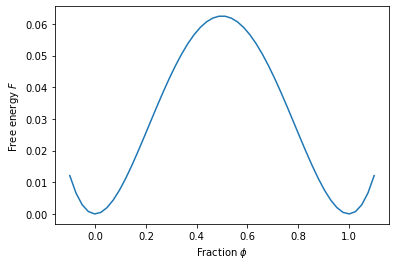

In [3]:
c = np.linspace(-0.1, 1.1)
plt.plot(c, c**2 * (1 - c)**2)
plt.xlabel('Fraction $\phi$')
plt.ylabel(r'Free energy $F$');

### Problem 2

First adjust the right hand side of `pde.PDE` to include chemical reactions $s(c)=-k(c-c_0)$.<br>
Then run the simulation for $k=5\cdot10^{-3}$ and $c_0=0.1$. How does the average concentration develop over time? Why is it different from the case without reactions?

Afterwards find a function that describes the average concentratoin over time $\bar{c}(t)$ in terms of the initial average concentration $\bar{c}(t=0)$ and the reaction parameters $k$ and $c_0$.

In [4]:
# define the partial differential equation
k = 5.e-3
c0 = 0.1

eq = pde.PDE({'c': '2*laplace(c * (1 - c) * (1 - 2*c) - laplace(c))'})

  0%|          | 0/1000.0 [00:00<?, ?it/s]

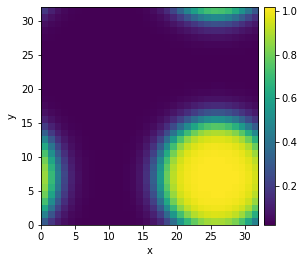

In [5]:
# prepare a random initial state
grid = pde.UnitGrid([32, 32], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=0.5)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq.solve(initial_state, t_range=1000, dt=1.e-3, tracker=['progress', storage.tracker(10)])
final_state.plot();

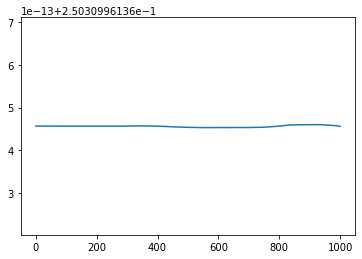

In [6]:
avs = np.zeros(len(storage.data))
for i in range(len(storage.data)):
    avs[i] = np.average(storage.data[i])
ts = np.asarray(storage.times)

plt.plot(ts,avs)
plt.show()
plt.close()

### Solution

The average concentration decays exponetially towards $c_0$. Mass is not conserved anymore, because the stable fixpoint for the reaction is $c_0$ independent of the initial average concentration.
The average concentration can be described by $\bar{c}(t)=c_0+(\bar{c}(t=0)-c_0)\exp(-kt)$

In [7]:
eq2 = pde.PDE({'c': f'laplace(2 * c * (1 - c) * (1 - 2*c) - 2*laplace(c)) - {k} * (c - {c0})'})
eq2.expressions

# prepare a random initial state
grid = pde.UnitGrid([20, 20], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=0.5)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=1000, dt=1.e-3, tracker=['progress', storage.tracker(10)])
final_state.plot(vmin=0,vmax=1);

avs = np.zeros(len(storage.data))
for i in range(len(storage.data)):
    avs[i] = np.average(storage.data[i])
ts = np.asarray(storage.times)
plt.plot(ts,c0+(avs[0]-c0)*np.exp(-k*ts),ls='--',color='k')
plt.plot(ts,avs)
plt.show()
plt.close()

  0%|          | 0/1000.0 [00:00<?, ?it/s]

### Droplets with chemical reactions

For the initial condition and $c_0=0.1$ used above the system ends up in a homogeneous state with $c(x,y)=c_0$ everywhere. But It is possible to form droplets with chemical reactions as well. For example increasing $c_0$ and the initial average concentration leads to the formation of a droplet.

In [8]:
# define the partial differential equation
k = 5.e-3
c0 = 0.25

eq2 = pde.PDE({'c': f'2*laplace(c * (1 - c) * (1 - 2*c) - laplace(c)) - {k} * (c - {c0})'})
eq2.expressions

{'c': '-0.005*c + 2.0*laplace(c*(c - 1)*(2*c - 1) - laplace(c)) + 0.00125'}

  0%|          | 0/3000.0 [00:00<?, ?it/s]

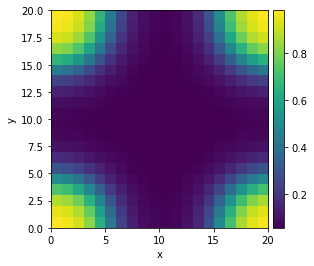

In [9]:
# prepare a random initial state
grid = pde.UnitGrid([20, 20], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=.5)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=3000, dt=1.e-2, tracker=['progress', storage.tracker(10)])
final_state.plot();

### Problem 3
Plot the time evolution of the average concentration, is it qualitatively different from the homogeneous case?<br>
Looking at the final state, how would the reaction rate inside and outside the droplet look like?<br>
Using `pde.ScalarField(grid,data=?)` function, plot the reaction rate corresponding to the final state of your simulation.

In [10]:
react = pde.ScalarField(grid, data=-k*(final_state.data-c0))
react.plot()

### Solution 3
It is qualitatively the same as in the homogeneous case, a exponential decay to $c_0$.<br>
The reaction is strongly negative inside the droplet and positive or zero outside.

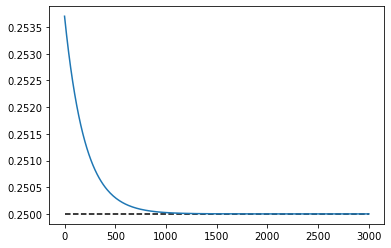

In [11]:
avs = np.zeros(len(storage.data))
for i in range(len(storage.data)):
    avs[i] = np.average(storage.data[i])
ts = np.asarray(storage.times)
plt.plot([0,ts[-1]],[c0,c0],color='k',ls='--')
plt.plot(ts,avs)
plt.show()
plt.close()

### Multiple stable droplets
In the last tutorial you have learned that droplets without reactions minimize the free energy by minimizing the total area and that Ostwald ripening leads to the formation of one large droplet. With chemical reactions it is possible to stabilize multiple droplets at the same time.

### Problem 4
In the above example you find only one droplet, what could be missing to see multiple stable droplets?<br>
Looking again at the dynamical equation

\begin{align}
    \partial_t c = a\cdot M\nabla^2[c(1-c)(1-2c)- \nabla^2c] - k(c-c_0),
\end{align}

where $a\cdot M=D=2$ and $k=5\cdot10^{-3}$, what are the units of $D$ and $k$?<br>
Using diffusivity $D$ and reaction rate $k$, built a length scale.<br>
How big is this length scale, the reaction diffusion length $\ell$, compared to system size?<br>
Simulate the system for a square with side length $5\ell$ and describe in what you observe in the video and the final state.

  0%|          | 0/5000.0 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

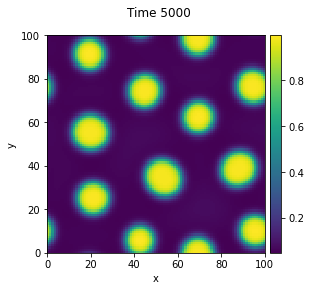

In [12]:
# prepare a random initial state
grid = pde.UnitGrid([100, 100], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=1.)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=5000, dt=1.e-2, tracker=['progress', storage.tracker(10)])
final_state.plot();

pde.movie(storage, f'multiple_droplets{k}.mp4', progress=True)

### Solution 4
Units of $D$ are $L^2/T$ and units of $k$ are $1/T$. The length scale is $\ell=\sqrt{D/k}=20$, system size is $L=20$ so its $L~1\ell$. For $L=5\ell$ we see multiple droplets of simiilar size with similar spacing.

### Problem 5

In what pattern do the droplets arrange and why?<br>
Not all droplets attain exactly the same size for this simulation time, would they end up at the same size if you simulate infinitely long?

### Solution 5

They arrange in a hexagonal pattern, because it is the closed packing solution in 2D. As a hexagonal pattern does not fit into a quadratic box it is possible that the steady state contains defects and not all droplets attain exactly the same time even for infinite simulation time.

### Droplet size depends on length scale $\ell$

Using the interface width between droplet and dilute phase $w=\sqrt{\kappa/a}$ (here $w=1$) as one length scale and introducing a time scale $\tau = w^2/D$, we can rewrite the dynamical equation in dimensionless form as

\begin{align}
    \partial_t c = \nabla^2 [c(1-c)(1-2c) - \nabla^2c] - \frac{w^2}{\ell^2}(c-c_0)
\end{align}

where the ratio between interface width and reaction diffusion length $w^2/\ell^2$ is the only parameter left.

### Problem 6

How do you expect droplet size and distance to change when $\ell$ is increased/decreased?

Simulate the system for $k=1\cdot 10^{-3}$, $k=2\cdot 10^{-2}$ and $k=5\cdot 10^{-2}$ and see how the droplet radii and the pattern change using the final state.

In [39]:
# define the partial differential equation
k = 3.e-2
D = 2
c0 = 0.25
w=1
ell = np.sqrt(D/k)
ellsq = D/k

eq2 = pde.PDE({'c': f'laplace(c * (1 - c) * (1 - 2*c) - laplace(c)) - {w}*{w}/{ellsq} * (c - {c0})'})
eq2.expressions

{'c': '-0.015*c + laplace(c*(c - 1)*(2*c - 1) - laplace(c)) + 0.00375'}

In [40]:
# prepare a random initial state
grid = pde.UnitGrid([100, 100], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=1.)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=5000, dt=1.e-2, tracker=['progress', storage.tracker(10)])
final_state.plot(vmin = 0, vmax = 1);
pde.movie(storage, 'hexagonal_pattern.mp4', progress=True)

  0%|          | 0/5000.0 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

### Solution 6

Increasing $\ell$ (decreasing $k$) leads to larger droplets and decreasing $\ell$ (increasing $k$) leads to smaller droplets. For the same simulation time the fast reaction simulations lead to more uniform distributions. Droplets dissolve for too fast reactions, e.g. $k=5\cdot 10^{-2}$.

The lattice looks more hexagonal for $k=2\cdot10^{-2}$.

### Analyzing the results

To get quantitative results for the droplet sizes and distributions it is necessary to extract individual droplet sizes and distances from the `final_state`. In a first step we convert the final state into a binary array where everything above $c>0.5$ gets converted to $1$ and counts as drolet phase while everything below becomes $0$ and belongs to the dilute phase.

We then use the `scipy.ndimage.measurements.label` function to identify clusters of ones, which correspond to droplets. The function `scipy.ndimage.measurements.sum` is used to sum up all pixels that belong to a certain cluster<br>
See <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html#scipy.ndimage.label">here</a> for a documentation of the function.

25


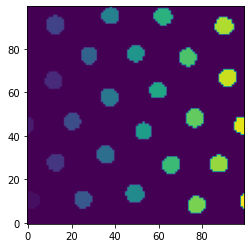

In [41]:
binary = np.where(final_state.data>0.5,1,0)

from scipy.ndimage import measurements
labels, num = measurements.label(binary)

plt.imshow(labels.T,origin='lower')
print(num)

indices = range(1, num + 1)

Sum = measurements.sum(binary,labels, index=indices)

### Problem 7

Use the sum of each cluster to calculate the radius of each individual cluster and plot the histogram using the `plt.hist(x)` function. In addition calculate the mean radius and the standard deviation.

How can you use the binary image to come up with a first order approximation for the average droplet radius?

Why is this simple cluster analysis problematic and what can be done to improve it?

### Solution 7

Because it does not include the effect of periodic boundary conditions. We could change the distance function by hand or just duplicate the image or increase system size so the boundaries becomoe negligible.

Assuming that all droplets have the same size and we have $N$ droplets, integrating the binary picture and dividing it by $N$ gives a first order approximation of the average droplet.

In [42]:
radii = np.sqrt(Sum/np.pi/4)
plt.hist(radii)

(array([ 1.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  5., 15.]),
 array([0.97720502, 1.09432151, 1.211438  , 1.3285545 , 1.44567099,
        1.56278748, 1.67990397, 1.79702046, 1.91413695, 2.03125344,
        2.14836993]),
 <BarContainer object of 10 artists>)

One simple way to reduce the effect of periodic boundaries is to duplicate the final state and create a artificially bigger box. Repeat the steps above, plot the histogram and calculate mean and standard deviation of the droplets.

In [43]:
offset = np.array([dim if p else 0 for p, dim in zip(grid.periodic, grid.shape)])
pad = np.c_[offset, offset].astype(np.intc)
mask_padded = np.pad(binary, pad, mode="wrap")
assert np.all(mask_padded.shape == np.array(grid.shape) + 2 * offset)
# locate individual clusters in the padded image
labels, num_labels = measurements.label(mask_padded)

plt.imshow(labels.T,origin='lower')
plt.show()
plt.close()

indices = range(1, num_labels + 1)

volumes = measurements.sum(mask_padded, labels, index=indices)

### Investigate droplet distances

One way to test the average distance between droplets is the radial distribution function (rdf). The rdf is usually used to investigate the nearest neighbour distance of particles e.g. in a fluid or crystal. But by describing the position of a droplet by its center of mass we can treat droplets as particles and check the nearest neighbor distance. The rdf is a function of distance $r$ and indicates the average probability to find another particle in an annullus between $r$ and $r+dr$ from the center of a particle. 

We here use a predefined function someone uploaded on github <a href="https://github.com/cfinch/Shocksolution_Examples/blob/master/PairCorrelation/paircorrelation.py">here</a>. It takes the $x$ and $y$ positions of all droplets, the total system size $S$ of the quadratic box, the maximum distance you want to check rMax and the annullus size $dr$ and returns the rdf and the distances.

In [44]:
''' The code for the pair Correlation Function in 2D is from
https://github.com/cfinch/Shocksolution_Examples/blob/master/PairCorrelation/paircorrelation.py '''

def pairCorrelationFunction_2D(x, y, S, rMax, dr):
    """Compute the two-dimensional pair correlation function, also known
    as the radial distribution function, for a set of circular particles
    contained in a square region of a plane.  This simple function finds
    reference particles such that a circle of radius rMax drawn around the
    particle will fit entirely within the square, eliminating the need to
    compensate for edge effects.  If no such particles exist, an error is
    returned. Try a smaller rMax...or write some code to handle edge effects! ;)
    Arguments:
        x               an array of x positions of centers of particles
        y               an array of y positions of centers of particles
        S               length of each side of the square region of the plane
        rMax            outer diameter of largest annulus
        dr              increment for increasing radius of annulus
    Returns a tuple: (g, radii, interior_indices)
        g(r)            a numpy array containing the correlation function g(r)
        radii           a numpy array containing the radii of the
                        annuli used to compute g(r)
        reference_indices   indices of reference particles
    """
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram
    # Number of particles in ring/area of ring/number of reference particles/number density
    # area of ring = pi*(r_outer**2 - r_inner**2)

    # Find particles which are close enough to the box center that a circle of radius
    # rMax will not cross any edge of the box
    bools1 = x > rMax
    bools2 = x < (S - rMax)
    bools3 = y > rMax
    bools4 = y < (S - rMax)
    interior_indices, = where(bools1 * bools2 * bools3 * bools4)
    num_interior_particles = len(interior_indices)

    if num_interior_particles < 1:
        raise  RuntimeError ("No particles found for which a circle of radius rMax\
                will lie entirely within a square of side length S.  Decrease rMax\
                or increase the size of the square.")

    edges = arange(0., rMax + 1.1 * dr, dr)
    num_increments = len(edges) - 1
    g = zeros([num_interior_particles, num_increments])
    radii = zeros(num_increments)
    numberDensity = len(x) / S**2

    # Compute pairwise correlation for each interior particle
    for p in range(num_interior_particles):
        index2 = interior_indices[p]
        d = sqrt((x[index2] - x)**2 + (y[index2] - y)**2)
        d[index2] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, density=False)
        g[p, :] = result/numberDensity

    # Average g(r) for all interior particles and compute radii
    g_average = zeros(num_increments)
    for i in range(num_increments):
        radii[i] = (edges[i] + edges[i+1]) / 2.
        rOuter = edges[i + 1]
        rInner = edges[i]
        g_average[i] = mean(g[:, i]) / (pi * (rOuter**2 - rInner**2))

    return (g_average, radii, interior_indices)

In [50]:
print(np.mean(volumes),np.std(volumes))
print(np.mean(radii),np.std(radii))
#plt.hist(volumes)
plt.imshow(labels.T,origin='lower')

positions = measurements.center_of_mass(mask_padded, labels, index=indices)
# correct for the additional padding of the array
positions = grid.transform(positions, "cell", "grid")
xpos, ypos = positions[:,0], positions[:,1]
plt.scatter(xpos, ypos, s=1)

51.2112676056338 7.309872723806235
1.945563396758617 0.26962731638433046


### Problem 8

Calculate the radial distribution function and plot it. What is the average droplet distance?

What is different for high and low $\ell$?

/var/folders/dy/9_2jrg4s4zj7m6c8z14d5ntw0000gn/T/ipykernel_55451/2514928550.py:54: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  (result, bins) = histogram(d, bins=edges, normed=False)


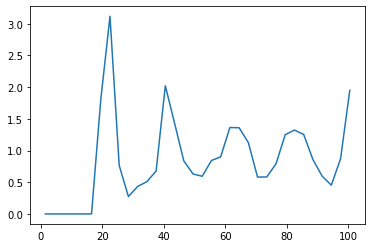

In [46]:
# Insert the right arguments for x, y, S, rMax, dr
rdf = pairCorrelationFunction_2D(xpos, ypos, S=256, rMax=100, dr=3)

plt.plot(rdf[1], rdf[0])
plt.show()
plt.close()

### Solution 8

The average droplet distance is $\sim 20$ and somewhat independent of $\ell$, but the peak gets broader for low $\ell$.

Another option to find length scales in a system is the discrete Fourier transform (FFT) that decomposes the field into exponential functions $\exp(i(\lambda_x x+\lambda_y y))$ with different wavevectors $\lambda_x$ and $\lambda_y$. Because in numerical simulations space is finite and discrete, the wavevectors are discrete as well. For a 2D quadratic grid with (even) sidelength $L$ and equal grid spacing $(d,d)$, the wavevectors are given by $\lambda_x,\lambda_y\in[-L/2,...,0,...,(L/2-1)]/(d \cdot L)$. The discrete Fourier transform for each point in space $(n\cdot d,m\cdot d),\; n,m\in[0,1,...,N-1]$ with $N=L/d$ is then given by a linear combination of all wavevectors

\begin{align}
    c(n\cdot d,m\cdot d) = \sum_{k=-N/2}^{N/2-1}\sum_{l=-N/2}^{N/2-1} \hat{c}\left(\frac{m}{L},\frac{l}{L}\right)\exp\left(2\pi i \left[\frac{k\cdot n}{N}+\frac{l\cdot m}{N}\right]\right),
\end{align}

where $\hat{c}\left(\frac{m}{L},\frac{l}{L}\right)$ is the amplitude of the corresponding wavevectors and indicates how strong it contributes. Unlike the rdf the 2D Fourier transform keeps information not only about the distance but the orientation as well.

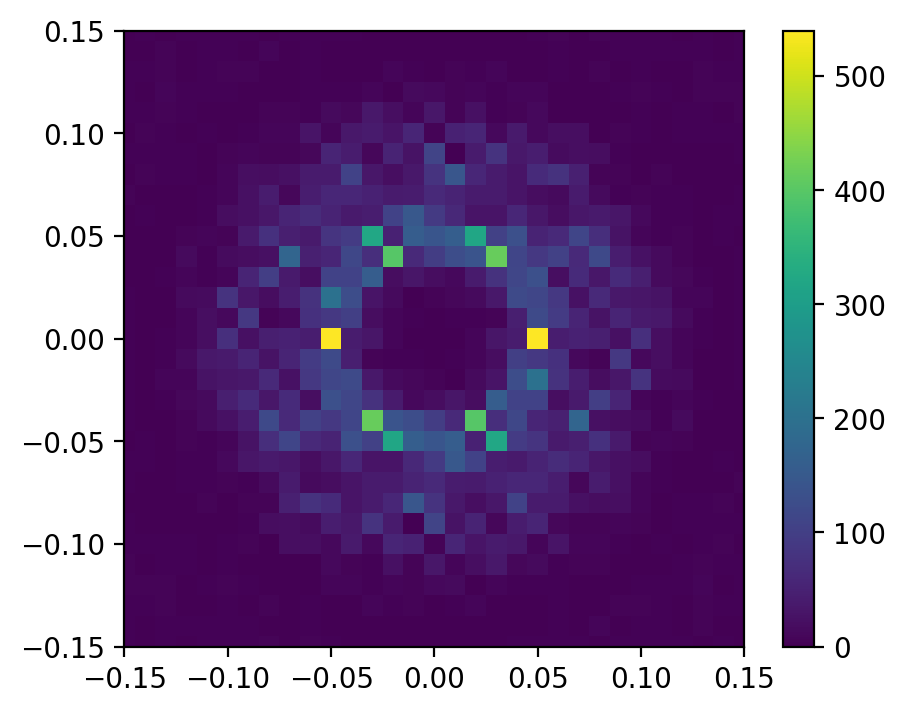

In [38]:
from scipy.fft import fft2, fftfreq, fftshift

# Calculate the FFT of the final state
# The absolute is taken, because the FFT returns complex values
c_hat = np.abs(fftshift(fft2(final_state.data)))
c_hat[50,50]=0 # The peak at wavevector (0,0) is set to zero

# Define the wavevectors corresponding to the grid of length L=100 and spacing d=1
kx, ky = fftshift(fftfreq(100,1)), fftshift(fftfreq(100,1)) 
kxp, kyp = np.meshgrid(kx, ky, sparse=False, indexing='ij')


plt.figure(figsize=(5,4))
plt.pcolormesh(kxp,kyp,c_hat)
plt.colorbar()
plt.axis([-0.15,0.15,-0.15,0.15])
plt.show()
plt.close()
# A 1 dimensional cut is plotted for lambda_y=0, lambda_x between 0 and 0.2
plt.plot(kx,c_hat[50,:])
plt.axis([0,0.2,0,500])
plt.show()
plt.close()

### Problem 9

Compare the peak position of $\hat{c}(\lambda_x,\lambda_y=0)$ to the average distance from the rdf.

Simulate the system for $k=3\cdot 10^{-2}$ for $L=100$ and $L=500$, how does the image of the FFT change and why?

### Solution 9

The peak is at $\lambda_x\approx 0.05$ which corresponds to $l_x=20$ and is very similar to the first rdf peak.

For $L=100$ the hexagonal pattern is clearly visible, but it smears out for $L=500$. In large systems the orientation of the pattern changes in space and thus no clear hexagonal orientation is visible.

### Additional Problems

### Linear stability analysis

In the lecture by Prof. Frey you learned about linear stability analysis to investigate the onset of pattern formation and wave vector selection. Apply this technique to the problem discussed in this session

\begin{align}
    \partial_t c = \nabla^2[c\cdot(1-c)(1-2c)-\nabla^2 c] - \frac{w^2}{\ell^2}(c-c_0)
\end{align}

for $c_0=0.25$ by applying a pertubation $\delta c(\vec{r},t)=\epsilon \exp(\omega t - i\vec{k}\vec{r})$ around the homogeneous state $c_0$: $c(\vec{r},t) = c_0 + \delta c(\vec{r},t)$.

What is the most unstable wavevector $\vec{k}$ and how does it compare to the pattern length scale you found in the simulation?

### Droplet size as a function of reaction diffusion length

Above you did simulations for a selected set of reaction diffusion length $\ell$ and discussed the dependence of droplet size on $\ell$ only qualitatively. Use the framework you learned in the notebooks `day1_3_reaction-diffusion` and `day2_1_pole-to-pole` for parameter sweeps, numerically determine the mean radius $\bar{R}$ as a function of $\ell$ for $\ell\in[10^{-2},10^{-4}]$. <br>
Afterwards find an analytical function $\bar{R}(\ell)$ and fit it to your data.

### Droplet growth dynamics

Use a spherical grid (see notebook `day1_1_Introduction_to_py-pde_solution`) with a small droplet centered at $r=0$ as initial condition. Let the system evolve in time and use the `pde.MemoryStorage()` to investigate the growth rate of the droplet as a function of $\ell$.